<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"></ul></div>

In [1]:
import sys
import os
import json
import logging
from queue import Queue
logging.basicConfig(level=logging.INFO)
sys.path.insert(0, os.path.dirname(os.getcwd()))
os.chdir('../')

In [2]:
import util
from util.osm import OSM
from util.lidar import Lidar

import logging
# create logger
logger = logging.getLogger('PolyLidar')
logger.setLevel(logging.INFO)


from scipy.spatial import Delaunay
import ipyvolume as ipv
import matplotlib.cm as cm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import shapely
from shapely.ops import cascaded_union
from shapely.geometry import asPolygon


with open('data/example.json') as f:
    example = json.load(f)

osm = OSM(bbox=example['bbox'], **example['osm'])
# print(osm.tables['osm_buildings'])

lidar = Lidar(proj_osm=osm.proj, **example['lidar'])
flat_buildings = [building for building in osm.tables['osm_buildings'] if building['roof_shape'] == 'flat' and building['area'] > 25 ]

In [3]:
def get_normal(points):
#     print(points.shape)
    line1 = points[0,:] - points[1,:]
    line2 = points[1,:] - points[2,:]
    line3 = points[0,:] - points[2,:]
    normal1 = np.cross(line1, line2)
    normal2 = np.cross(line1, line3)
    normal1_n = normal1 / np.linalg.norm(normal1)
    normal2_n = normal2 / np.linalg.norm(normal2)
    dot1 = np.dot(normal1_n, np.array([0,0,1]))
    dot2 = np.dot(normal2_n, np.array([0,0,1]))
#     if dot1 > .98:
#         print(line1, line2)
#         print(dot1, dot2)
#     print(normal1_n, normal2_n)
    return normal1_n

def get_normals(points):
    norms_ = np.zeros((points.shape[0], 3))
    for i in range(0, points.shape[0]):
        norms_[i,:] = get_normal(points[i, :,:])
#     norms_avg = np.zeros_like(norms_)
#     for i in range(simplices.shape[0])
#         neighbor_norms = norms_[simplices[i,:]]
    return norms_
    
def search_sorted_improved(arr, val):
    idx = np.searchsorted(arr, val, side='left')
    if idx < arr.shape[0] and arr[idx] == val:
        return idx
    else:
        return None

## Normal Estimation by Fitting Planes

This has been preprocessed with white box tools. Ball of radius r, or neighbors k, then plane fitting.

Building ID: 68828206; centroid: 51.44025, 7.33707; area: 682.7625846427438; # points: 6654


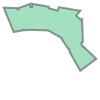

In [144]:
building = flat_buildings[0]

lidar_building, poly = lidar.get_lidar_building(building, filter_points=True, filter_dist=2)

print("Building ID: {}; centroid: {}; area: {}; # points: {}".format(building['uid'], building['centroid'], building['area'], lidar_building.shape[0]))
data =util.scale_points(lidar_building[:,0:3], legacy=False)
display(ipv.quickquiver(**data, u=lidar_building[:,3], v=lidar_building[:,4], w=lidar_building[:,5], size=2))

ipv.xlim(*data['extent'][0]) 
ipv.ylim(*data['extent'][1])
ipv.zlim(*data['extent'][2])
ipv.squarelim()

display(poly)

## Delauney Triangulation

Here we create a triangular mesh of every point. Normal is now calculated from the triangles.

Triangles: 13290, Points: 6654


<IPython.core.display.Javascript object>


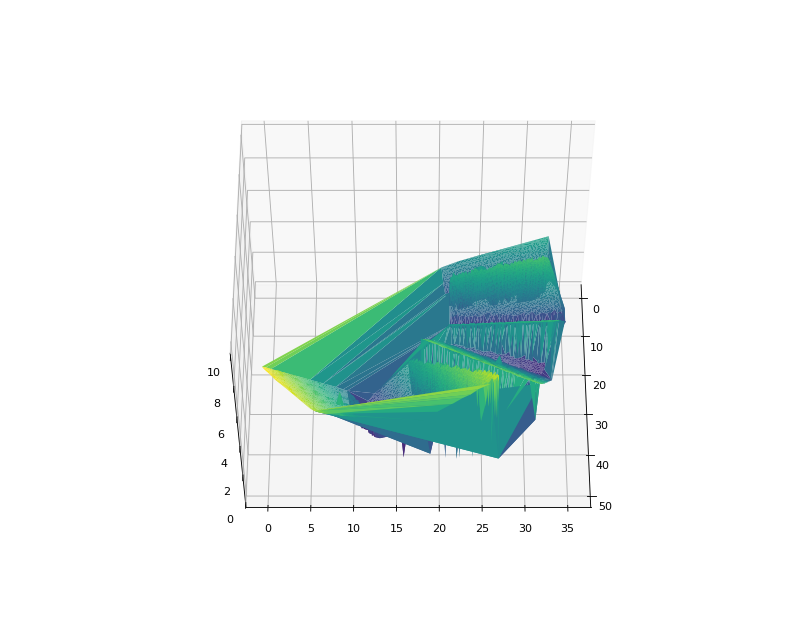

(0, 10)

In [102]:
# Project Points to XY plane. Normalize to ensure we dont have precison issues. I needed this.
points_2d = lidar_building[:,0:2] - lidar_building[:,0:2].min(axis=0)
points = lidar_building[:, 0:3] # 3D points of building, removing previosly computed normals from WBT
tri = Delaunay(points_2d, qhull_options="Qbb Qc Qz Qx Q12 Qt", furthest_site=False)
print("Triangles: {}, Points: {}".format(tri.simplices.shape[0], tri.points.shape[0]))

# %matplotlib qt5
%matplotlib notebook
# %matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,8), subplot_kw=dict(projection='3d'))
ax.plot_trisurf(*util.scale_points(points), triangles=tri.simplices, cmap=plt.cm.viridis)
ax.view_init(elev=55., azim=0)
ax.set_zlim(0, 10)

In [103]:
points_vertices = points[tri.simplices] # Points of vertices
points_ = points_vertices.mean(axis=1)  # Centroid of Triangles
# Calculate normal of triangles
norms = get_normals(points_vertices)

mask_norm = np.abs(np.dot(norms, np.array([0,0,1]))) > .98
filt_norms = norms[mask_norm]

# Plot the newly calculated normals of triangles
data =util.scale_points(points_[mask_norm,0:3], legacy=False)
display(ipv.quickquiver(*util.scale_points(points_[mask_norm,0:3]), filt_norms[:,0], filt_norms[:,1], filt_norms[:,2], size=2))
ipv.xlim(*data['extent'][0]) 
ipv.ylim(*data['extent'][1])
ipv.zlim(*data['extent'][2])
ipv.squarelim()

## Planar Roof Extraction

### Step 1

1. Calculate normal vectors of all trianngles
2. Find the subset of triangles, $S$, that have near perpinducular normals or have really small height difference in vertices.


### Step 2

1. Randomly pick a seed triangle within this set. Remove this triangle from $S$ and add to $C_{1}$. Candidate set one
2. Find conected traingular members to this triangle from $S$. Add them to $C_{1}$ and remove from $S$
3. For each element in $C_{1}$ that has not been expanded (looked at connected members) repeat 2
4. If $S$ is not empty, create a new candidate set, $C_2$, and repeat at 1 unitl $S$ is empty.

### Step 3

We will now have several several candidate sets, $C_i$, that are distinct flat planes.  We must now turn them into polygons

TODO


### Step 1 Visualization

In [108]:
def filter_triangles(tri, points, norms, norm=np.array([0,0,1]), norm_thresh=.98, z_thresh=.12):
    mask_small = np.ptp(points[tri.simplices][:, :, 2], axis=1) < z_thresh
    mask_norm = np.abs(np.dot(norms, np.array([0,0,1]))) > norm_thresh
#     print(norms.shape, tri.nsimplex)
#     tri_full = np.concatenate([tri.simplices,  np.expand_dims(np.arange(tri.nsimplex), 1)], axis=1)
    global_indices =  np.arange(tri.nsimplex)
    global_indices = global_indices[mask_norm | mask_small]
    return global_indices


<IPython.core.display.Javascript object>


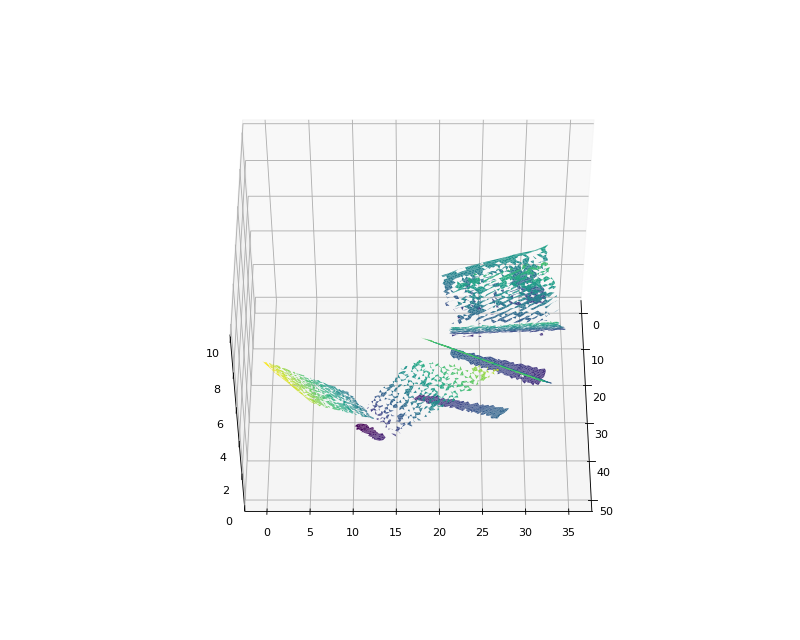

(0, 10)

In [109]:
global_indices = filter_triangles(tri, points, norms)
tri_zup = tri.simplices[global_indices,:]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,8), subplot_kw=dict(projection='3d'))
ax.plot_trisurf(*util.scale_points(points), triangles=tri_zup[:,0:3], cmap=plt.cm.viridis)
ax.view_init(elev=50., azim=0)
ax.set_zlim(0, 10)


## Ideas

After generating a candidate mesh fit a plane to all the points. Then go through every triangle and ask: does this triangle have the correct height and normal for its specific xyz central point of the fitted plane. If it does, keep it, if not then remove it.

After this you will have a triangular mesh that you should then post process to fill in *maybe* some holes. I really think that we should have very few holes (because of the small height difference check for each triangle).

Finally then create a polygon geometry from the mesh. The concave hull I'm guessing with holes.

## Step 2

<IPython.core.display.Javascript object>


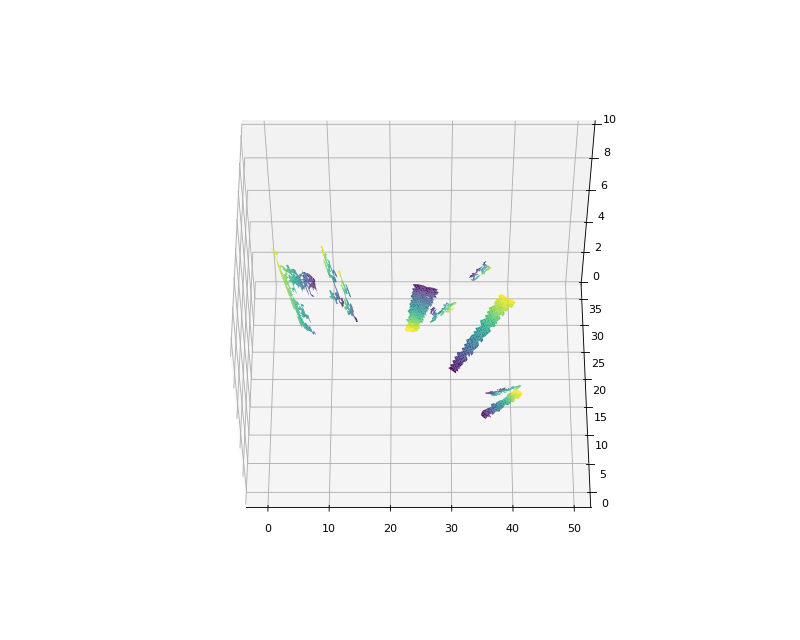

(0, 10)

In [141]:
logger.setLevel(logging.WARN)
np.random.seed(1)


def extract_mesh(tri, global_indices, in_set_flag, seed_idx):
    simplices = tri.simplices
    candidates_que = Queue()
    
    candidates_que.put(seed_idx)
    in_set_flag[search_sorted_improved(global_indices, seed_idx)] = False # Like Removing from set
    candidates = []
    while not candidates_que.empty():
        global_idx = candidates_que.get() # triangle index
        candidates.append(global_idx)

        logger.info("Triangle idx: {}".format(global_idx))
        neighbors = tri.neighbors[global_idx]
        logger.info("Neighbors: {} ".format(neighbors))
        for neighbor in neighbors:
            local_idx = search_sorted_improved(global_indices, neighbor)
            if local_idx is not None and in_set_flag[local_idx]:
                # This neighbor triangle is in tri_set and has a similar normal
                logger.info('Neighbor {} found in tri_set. Adding to candidate set'.format(neighbor))
                candidates_que.put(neighbor)
                # Remove from set
                in_set_flag[local_idx] = False
            else:
                logger.info("Neighbor {} not found. Points".format(neighbor, points[simplices[neighbor]]))

    return np.array(candidates)
    

def create_candidates(tri, global_indices):
    """Creates a candidate mesh's from 'similar' triangles in whose indices are in global_indices
    """
    global_indices = global_indices.copy()
#     global_indices = tri_set[:, 3] # view for simpler access
    in_set_flag = np.full(global_indices.shape, True, dtype=bool) # in set flag

    
    plane_patches = []
    while np.any(in_set_flag):
        filtered_indices = global_indices[in_set_flag]
        seed_idx = filtered_indices[np.random.choice(filtered_indices.shape[0])]
        logger.info("Seed Triangle idx: {}".format(seed_idx))       
        plane_patch = extract_mesh(tri, global_indices, in_set_flag, seed_idx)
        # Check if enough triangles are in this patch
        if plane_patch.shape[0] > 20:
            plane_patches.append(plane_patch)
        else:
            logger.info('Candidate set has two few triangles, discarding')
    return plane_patches

def filter_candidates(tri, plane_patches, min_bbox_area=16):
    filtered_patches = []
    for patch in plane_patches:
        patch_points = tri.points[tri.simplices[patch]]
        patch_points = patch_points.reshape(-1, patch_points.shape[-1])
        mins = np.min(patch_points,axis=0)
        maxs = np.max(patch_points,axis=0)
        bbox = (maxs[0] - mins[0]) * (maxs[1] - mins[1])
        if bbox >= min_bbox_area:
            filtered_patches.append(patch)
    return filtered_patches
    

plane_patches = create_candidates(tri, global_indices)
plane_patches = filter_candidates(tri, plane_patches)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,8), subplot_kw=dict(projection='3d'))
# Plot each plane patch
for patch_set in plane_patches:
    patch = tri.simplices[patch_set]
    ax.plot_trisurf(*util.scale_points(points), triangles=patch[:,:3], cmap=plt.cm.viridis)
    
ax.view_init(elev=55., azim=-90)
ax.set_zlim(0, 10)


### Step 3

Turn the triangular mesh inot a 2D polygon, **including** any holes that may exist.

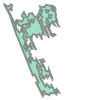

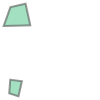

181


AttributeError: 'MultiPolygon' object has no attribute 'exterior'

In [158]:
polygons = []
patch = tri.simplices[plane_patches[2]]
triangles = tri.points[patch] 

for i in range(patch.shape[0]):
    tri_points = np.array(tri.points[patch[i,:]])
    polygon = np.vstack((tri_points, tri_points[0,:]))
    polygons.append(asPolygon(polygon))

building_polygon = cascaded_union(polygons)
display(building_polygon)
if building_polygon.area > 20 and not isinstance(poly, shapely.geometry.multipolygon.MultiPolygon):
    smoothed_building_polygon = building_polygon.buffer(-.5).buffer(.5).simplify(.5)
    display(smoothed_building_polygon)
    print(len(list(building_polygon.exterior.coords)))
    print(len(list(smoothed_building_polygon.exterior.coords)))
else:
    print('Buidling patch to small')
    smoothed_building_polygon = None
# display(smoothed_building_polygon)

In [157]:
triangles.shape

(529, 3, 2)

In [155]:
smoothed_building_polygon.type

'MultiPolygon'

In [154]:
list(smoothed_building_polygon.geoms)[0].type

'Polygon'

In [24]:
print(len(list(building_polygon.exterior.coords)))
print(len(list(smoothed_building_polygon.exterior.coords)))

52


AttributeError: 'NoneType' object has no attribute 'coords'

In [ ]:
%timeit cascaded_union(polygons)